# Logistic Regression

Logistic regression is a statistical and machine learning model used for **binary classification** tasks, where the output variable is categorical and takes one of two possible outcomes, typically labeled as 0 (negative class) and 1 (positive class).

## Key Concepts:
1. **Binary Classification**: Logistic regression predicts whether an input (feature vector) belongs to one of two classes.
   
2. **Sigmoid Function**: The logistic regression model applies the **sigmoid function** to a linear combination of input features to produce a probability value between 0 and 1.
   - The sigmoid function is defined as:
     - sigmoid(z) = 1 / (1 + exp(-z))
     - where z = w * X + b (a linear combination of the input features X, weights w, and bias b).

3. **Decision Threshold**: The probability output of the sigmoid function is compared to a threshold (usually 0.5) to determine the class label.
   - If sigmoid(z) >= 0.5, the class is predicted as 1 (positive class).
   - If sigmoid(z) < 0.5, the class is predicted as 0 (negative class).

4. **Model Equation**: Logistic regression has the form:
   - y = sigmoid(w * X + b)
   - where:
     - X is the input vector,
     - w are the weights (coefficients) of the features,
     - b is the bias (intercept),
     - sigmoid is the activation function.

5. **Loss Function**: The loss function used in logistic regression is **Binary Cross-Entropy Loss** (also called Log Loss), which measures how well the model’s predicted probabilities match the actual class labels:
   - Loss = - (1/N) * Σ [y_i * log(p_i) + (1 - y_i) * log(1 - p_i)]
   - where:
     - y_i is the true label (0 or 1),
     - p_i is the predicted probability for the positive class,
     - N is the number of samples.


In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# 0. Prepare data
# Load the breast cancer dataset from sklearn
#The Breast Cancer dataset (datasets.load_breast_cancer()) from the sklearn library is a well-known dataset that contains measurements for breast cancer tumors. 
#It is often used for binary classification tasks to predict whether a tumor is malignant (cancerous) or benign (non-cancerous)

bc = datasets.load_breast_cancer()
X, Y = bc.data, bc.target  # X is the feature matrix, Y is the target

# Get the number of samples and features
n_sample, n_features = X.shape

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

#Different features can have different scales. 
#Standardizing (scaling) the features ensures that each feature contributes equally to the model's performance
# Scale the data using StandardScaler (normalizes features to have mean 0 and variance 1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)  # Fit on training data and transform
X_test = sc.transform(X_test)        # Only transform the test data

#Split the training set into training and validation data point to ensure the model works well with unseen data.
#validation plot later on will saves us from overfitting training data, tunning hyperparameters,etc. 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=123)

# Convert numpy arrays to PyTorch tensors and ensure they are of type float32
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
X_val= torch.from_numpy(X_val.astype(np.float32))
Y_train = torch.from_numpy(Y_train.astype(np.float32))
Y_test = torch.from_numpy(Y_test.astype(np.float32))
Y_val=torch.from_numpy(Y_val.astype(np.float32))

# Reshape target tensors to be column vectors (necessary for binary classification)
Y_train = Y_train.view(Y_train.shape[0], 1)
Y_test = Y_test.view(Y_test.shape[0], 1)
Y_val= Y_val.view(Y_val.shape[0], 1)

In [3]:
# 1. Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        # Using nn.Sequential to define the model layers
        self.model = nn.Sequential(
            nn.Linear(n_input_features, 1),  # Linear layer: input features -> 1 output
            nn.Sigmoid()                      # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the model
    
# Create an instance of the model
model = LogisticRegression(n_features)

# 2. Define loss function and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer

In [4]:


# 3. Training loop
num_epochs = 100  # Set the number of training epochs

# Lists to store loss and accuracy values for plotting
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Loop over epochs
for epoch in range(num_epochs):
    # Forward pass on the training data
    y_predicted_train = model(X_train)
    train_loss = criterion(y_predicted_train, Y_train)  # Compute training loss
    train_loss_values.append(train_loss.item())  # Save training loss for plotting
    
    # Backward pass (compute gradients)
    train_loss.backward()
    
    # Update the weights using the optimizer
    optimizer.step()
    
    # Zero the gradients after updating to prevent accumulation
    optimizer.zero_grad()

    # Calculate training accuracy: accuracy = Total number of correct prediction /total prediction
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        y_predicted_train_cls = y_predicted_train.round()  # Convert probabilities to class labels (0 or 1)
        
        train_acc = y_predicted_train_cls.eq(Y_train).sum().item() / float(Y_train.shape[0])  
        #the eq() function creates a boolean tensor where each element is True if the corresponding predicted label matches the true label, and False otherwise

        train_accuracy_values.append(train_acc)

    # Validation phase (evaluate the model on the test set)
    with torch.no_grad():
        y_predicted_val = model(X_val)  # Predict on val data
        val_loss = criterion(y_predicted_val, Y_val)  # Compute validation loss
        val_loss_values.append(val_loss.item())  # Save validation loss for plotting
        
        # Calculate validation accuracy
        y_predicted_val_cls = y_predicted_val.round()  # Convert probabilities to class labels (0 or 1)
        val_acc = y_predicted_val_cls.eq(Y_val).sum().item() / float(Y_val.shape[0])  # Calculate accuracy
        val_accuracy_values.append(val_acc)

    # Print training and validation metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Train Loss = {train_loss.item():.4f}, '
              f'Validation Loss = {val_loss.item():.4f}, '
              f'Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}')



Epoch: 10, Train Loss = 0.6843, Validation Loss = 0.6406, Train Accuracy = 0.6015, Validation Accuracy = 0.6739
Epoch: 20, Train Loss = 0.5391, Validation Loss = 0.5058, Train Accuracy = 0.8411, Validation Accuracy = 0.8696
Epoch: 30, Train Loss = 0.4544, Validation Loss = 0.4258, Train Accuracy = 0.8949, Validation Accuracy = 0.9348
Epoch: 40, Train Loss = 0.3993, Validation Loss = 0.3739, Train Accuracy = 0.9046, Validation Accuracy = 0.9348
Epoch: 50, Train Loss = 0.3603, Validation Loss = 0.3375, Train Accuracy = 0.9144, Validation Accuracy = 0.9348
Epoch: 60, Train Loss = 0.3309, Validation Loss = 0.3106, Train Accuracy = 0.9193, Validation Accuracy = 0.9348
Epoch: 70, Train Loss = 0.3080, Validation Loss = 0.2897, Train Accuracy = 0.9267, Validation Accuracy = 0.9348
Epoch: 80, Train Loss = 0.2894, Validation Loss = 0.2730, Train Accuracy = 0.9315, Validation Accuracy = 0.9348
Epoch: 90, Train Loss = 0.2740, Validation Loss = 0.2592, Train Accuracy = 0.9340, Validation Accuracy =

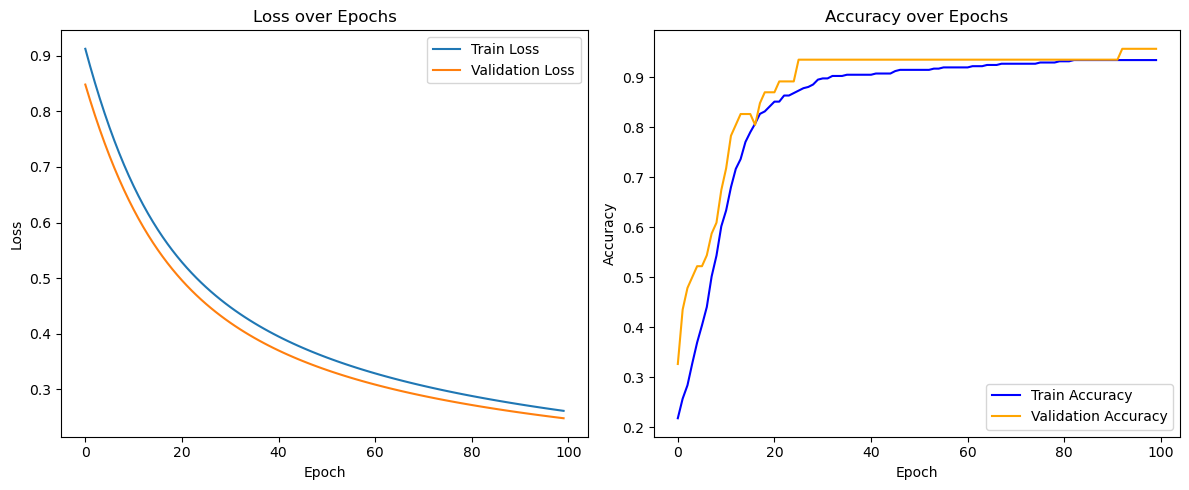

In [5]:
# 4. Plotting the training and validation metrics over epochs

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 5))  # Set the figure size for better visibility

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')  # Plot training loss
plt.plot(val_loss_values, label='Validation Loss')  # Plot validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy', color='blue')  # Plot training accuracy
plt.plot(val_accuracy_values, label='Validation Accuracy', color='orange')  # Plot validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()  # Adjust subplot layout
plt.show()  # Display the plot

# Confusion Matrix and ROC Curve 

## Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model by comparing predicted labels with actual labels.

### Structure of a Confusion Matrix

|                | Predicted Positive (1) | Predicted Negative (0) |
|----------------|------------------------|------------------------|
| **Actual Positive (1)** | True Positive (TP)       | False Negative (FN)      |
| **Actual Negative (0)** | False Positive (FP)      | True Negative (TN)       |

### Terminology
- **True Positive (TP)**: The model correctly predicted the positive class.
- **True Negative (TN)**: The model correctly predicted the negative class.
- **False Positive (FP)**: The model incorrectly predicted the positive class (Type I error).
- **False Negative (FN)**: The model incorrectly predicted the negative class (Type II error).

The confusion matrix provides a comprehensive view of how well the model is performing for each class. By looking at the matrix, we can identify which classes are being predicted correctly and which are being confused with others.

## ROC Curve

The ROC curve is a graphical representation used to assess the performance of a binary classification model at various threshold settings.

### Components of the ROC Curve
- **True Positive Rate (TPR)**: The proportion of actual positive cases correctly identified by the model.Also known as sensitivity or recall, calculated as:
  \[
  \text{TPR} = \frac{TP}{TP + FN}
  \]
- **False Positive Rate (FPR)**:The proportion of actual negative cases incorrectly classified as positive by the model. Calculated as:
  \[
  \text{FPR} = \frac{FP}{FP + TN}
  \]

### Characteristics of the ROC Curve
- The x-axis represents the **False Positive Rate**, while the y-axis represents the **True Positive Rate**.
- The curve is plotted by varying the threshold used to classify predictions.
- A **random classifier** will yield a diagonal line from (0,0) to (1,1), indicating no discrimination between classes.

### Area Under the Curve (AUC)
- The area under the ROC curve (AUC) provides a single metric to evaluate the model’s performance:
  - **AUC = 1**: Perfect model.
  - **AUC = 0.5**: No discrimination (similar to random guessing).
  - **AUC < 0.5**: The model is performing worse than random guessing.

## Importance
- **Confusion Matrix**: Provides detailed insight into the types of errors the model is making, especially useful in imbalanced datasets.
- **ROC Curve**: Helps visualize the trade-off between sensitivity and specificity across different thresholds, valuable for selecting an optimal threshold based on specific application requirements.


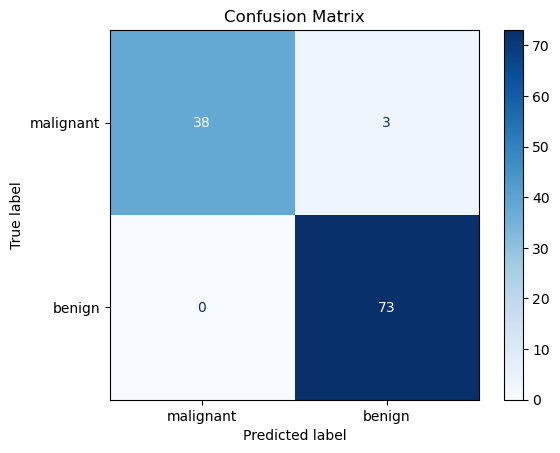

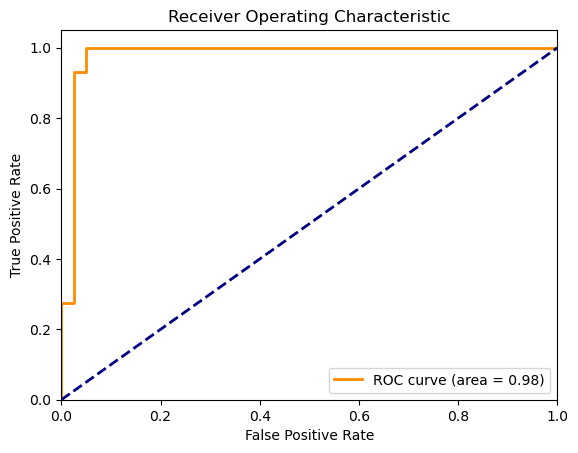

In [6]:
# 4. Confusion Matrix
with torch.no_grad():
    y_predicted_test = model(X_test)
    y_predicted_cls = y_predicted_test.round().numpy()

cm = confusion_matrix(Y_test.numpy(), y_predicted_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bc.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test.numpy(), y_predicted_test.numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **PHYS 323 : Logistic Regression on Z Boson Decay**

**Due Date**: update in the seminar

---

### **Objective**:
In this assignment, you will apply logistic regression to classify whether the Z boson decays into \( \mu^+ \mu^- \) (muons) or \( e^+ e^- \) (electrons) using the provided dataset. You will train the model, evaluate its performance, and visualize key metrics.

---

### **Dataset Information**:
You will use the `Z_boson.csv` dataset, which contains features corresponding to events where the Z boson decays into two different modes: \( \mu^+ \mu^- \) (muons) and \( e^+ e^- \) (electrons). Your task is to use these features to classify which decay mode the Z boson is undergoing.

- **Dataset Location**: `/home/bhanda25/Phys323_fall2024/Root_files/Z_boson.csv`

---

### **Instructions**:

#### **Part 1: Data Loading and Preprocessing**
1. Load the dataset using pandas.
2. Explore the dataset to understand its structure and features.
3. Preprocess the data:
    - Check for missing values and handle them accordingly.
    - Normalize or scale the features if necessary.
    - Create the target variable for classification (`0` for muons \( \mu^+ \mu^- \), and `1` for electrons \( e^+ e^- \)).

#### **Part 2: Logistic Regression Model**
1. Split the data into training and testing sets.
    - Use 80% of the data for training and 20% for testing.Also out of the 80% of training select 10% for validation
2. Implement logistic regression using `sklearn`.
3. Train the logistic regression model on the training data.

#### **Part 3: Model Evaluation**
1. Evaluate the performance of the model on the test data.
    - Print the accuracy score.
    - Plot the loss (cost function) over training epochs.
    - Plot accuracy versus training epochs.
2. Plot a confusion matrix to show the performance of the model.

#### **Part 4: Visualization**
1. Plot the following:
    - Loss vs Epoch
    - Accuracy vs Epoch
    - Confusion Matrix

---

### **Deliverables**:
Present you updates in the seminar with the proper introduction and slides 

---

### **Starter Code**:

```python
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the Z boson dataset
df = pd.read_csv('/home/bhanda25/Phys323_fall2024/Root_files/Z_boson.csv')

# convert to numeric
df['class'] = df['class'].map({'Zee': 0, 'Zmumu': 1})
df = df.drop(['Unnamed: 0'], axis=1) # remove unwanted column
df

# now start splitting into training and testing datasets 
```